# Similarity Queries using Annoy Tutorial

This tutorial is about using the ([Annoy Approximate Nearest Neighbors Oh Yeah](https://github.com/spotify/annoy "Link to annoy repo")) library for similarity queries with a Word2Vec model built with gensim.

## Why use Annoy?
The current implementation for finding k nearest neighbors in a vector space in gensim has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors. The retrieved results are exact, which is an overkill in many applications: approximate results retrieved in sub-linear time may be enough. Annoy can find approximate nearest neighbors much faster.


## Prerequisites
Additional libraries needed for this tutorial:
- annoy
- psutil
- matplotlib

## Outline
1. Download Text8 Corpus
2. Build Word2Vec Model
3. Construct AnnoyIndex with model & make a similarity query
4. Verify & Evaluate performance
5. Evaluate relationship of `num_trees` to initialization time and accuracy
6. Work with Google's word2vec C formats

In [1]:
# pip install watermark
%reload_ext watermark
%watermark -v -m -p gensim,numpy,scipy,psutil,matplotlib

CPython 3.5.3
IPython 6.2.1

gensim 3.0.1
numpy 1.13.3
scipy 1.0.0
psutil 5.4.0
matplotlib 2.1.0

compiler   : GCC 6.3.0 20170406
system     : Linux
release    : 4.10.0-37-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


### 1. Download Text8 Corpus

In [2]:
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip

#### Import & Set up Logging
I'm not going to set up logging due to the verbose input displaying in notebooks, but if you want that, uncomment the lines in the cell below.

In [3]:
LOGS = False

if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### 2. Build Word2Vec Model

In [4]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison

params = {
    'alpha': 0.05,
    'size': 100,
    'window': 5,
    'iter': 5,
    'min_count': 5,
    'sample': 1e-4,
    'sg': 1,
    'hs': 0,
    'negative': 5
}

model = Word2Vec(Text8Corpus('text8'), **params)
print(model)

Word2Vec(vocab=71290, size=100, alpha=0.05)


See the [Word2Vec tutorial](word2vec.ipynb) for how to initialize and save this model.

#### Comparing the traditional implementation and the Annoy approximation

In [5]:
# Set up the model and vector that we are using in the comparison
from gensim.similarities.index import AnnoyIndexer

model.init_sims()
annoy_index = AnnoyIndexer(model, 100)

In [6]:
# Dry run to make sure both indices are fully in RAM
vector = model.wv.syn0norm[0]
model.most_similar([vector], topn=5, indexer=annoy_index)
model.most_similar([vector], topn=5)

[('the', 0.9999999403953552),
 ('of', 0.8254586458206177),
 ('in', 0.8207480907440186),
 ('a', 0.7935141324996948),
 ('and', 0.7539303302764893)]

In [7]:
import time
import numpy as np

In [8]:
def avg_query_time(annoy_index=None, queries=1000):
    """
    Average query time of a most_similar method over 1000 random queries,
    uses annoy if given an indexer
    """
    total_time = 0
    for _ in range(queries):
        rand_vec = model.wv.syn0norm[np.random.randint(0, len(model.wv.vocab))]
        start_time = time.clock()
        model.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.clock() - start_time
    return total_time / queries

In [9]:
queries = 10000

gensim_time = avg_query_time(queries=queries)
annoy_time = avg_query_time(annoy_index, queries=queries)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
speed_improvement = gensim_time / annoy_time
print ("\nAnnoy is {0:.2f} times faster on average on this particular run".format(speed_improvement))

Gensim (s/query):	0.02066
Annoy (s/query):	0.00038

Annoy is 54.59 times faster on average on this particular run



**This speedup factor is by no means constant** and will vary greatly from run to run and is particular to this data set, BLAS setup, Annoy parameters(as tree size increases speedup factor decreases), machine specifications, among other factors.

>**Note**: Initialization time for the annoy indexer was not included in the times. The optimal knn algorithm for you to use will depend on how many queries you need to make and the size of the corpus. If you are making very few similarity queries, the time taken to initialize the annoy indexer will be longer than the time it would take the brute force method to retrieve results. If you are making many queries however, the time it takes to initialize the annoy indexer will be made up for by the incredibly fast retrieval times for queries once the indexer has been initialized

>**Note** : Gensim's 'most_similar' method is using numpy operations in the form of dot product whereas Annoy's method isnt. If 'numpy' on your machine is using one of the BLAS libraries like ATLAS or LAPACK, it'll run on multiple cores(only if your machine has multicore support ). Check [SciPy Cookbook](http://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html) for more details.

## 3. Construct AnnoyIndex with model & make a similarity query

### Creating an indexer
An instance of `AnnoyIndexer` needs to be created in order to use Annoy in gensim. The `AnnoyIndexer` class is located in `gensim.similarities.index`

`AnnoyIndexer()` takes two parameters:

**`model`**: A `Word2Vec` or `Doc2Vec` model

**`num_trees`**: A positive integer. `num_trees` effects the build time and the index size. **A larger value will give more accurate results, but larger indexes**. More information on what trees in Annoy do can be found [here](https://github.com/spotify/annoy#how-does-it-work). The relationship between `num_trees`, build time, and accuracy will be investigated later in the tutorial. 

Now that we are ready to make a query, lets find the top 5 most similar words to "science" in the Text8 corpus. To make a similarity query we call `Word2Vec.most_similar` like we would traditionally, but with an added parameter, `indexer`. The only supported indexer in gensim as of now is Annoy. 

In [10]:
# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model, 100)
# Derive the vector for the word "science" in our model
vector = model["science"]
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = model.most_similar([vector], topn=11)
print("\nNormal (not Annoy-indexed) Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('science', 1.0)
('multidisciplinary', 0.6066591441631317)
('astrobiology', 0.5995452105998993)
('actuarial', 0.5984143614768982)
('robotics', 0.5919757187366486)
('sciences', 0.5884003043174744)
('scientific', 0.5805909633636475)
('interdisciplinary', 0.5763890445232391)
('astronautics', 0.5748652517795563)
('psychohistory', 0.5744689702987671)
('aaas', 0.574154257774353)

Normal (not Annoy-indexed) Neighbors
('science', 1.0)
('fiction', 0.7570418119430542)
('multidisciplinary', 0.6905661225318909)
('astrobiology', 0.6792721152305603)
('actuarial', 0.6774581670761108)
('robotics', 0.6670321822166443)
('vinge', 0.6633784770965576)
('sciences', 0.6611713767051697)
('vernor', 0.6521490812301636)
('popularizer', 0.6499912738800049)
('scientific', 0.648192286491394)


#### Analyzing the results

The closer the cosine similarity of a vector is to 1, the more similar that word is to our query, which was the vector for "science". There are some differences in the ranking of similar words and the set of words included within the 10 most similar words.

### 4. Verify & Evaluate performance

#### Persisting Indexes
You can save and load your indexes from/to disk to prevent having to construct them each time. This will create two files on disk, _fname_ and _fname.d_. Both files are needed to correctly restore all attributes. Before loading an index, you will have to create an empty AnnoyIndexer object.

In [11]:
fname = '/tmp/mymodel.index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

In [12]:
# Results should be identical to above
vector = model["science"]
approximate_neighbors2 = model.most_similar([vector], topn=11, indexer=annoy_index2)
for neighbor in approximate_neighbors2:
    print(neighbor)
    
assert approximate_neighbors == approximate_neighbors2

('science', 1.0)
('multidisciplinary', 0.6066591441631317)
('astrobiology', 0.5995452105998993)
('actuarial', 0.5984143614768982)
('robotics', 0.5919757187366486)
('sciences', 0.5884003043174744)
('scientific', 0.5805909633636475)
('interdisciplinary', 0.5763890445232391)
('astronautics', 0.5748652517795563)
('psychohistory', 0.5744689702987671)
('aaas', 0.574154257774353)


Be sure to use the same model at load that was used originally, otherwise you will get unexpected behaviors.

#### Save memory by memory-mapping indices saved to disk

Annoy library has a useful feature that indices can be memory-mapped from disk. It saves memory when the same index is used by several processes.

Below are two snippets of code. First one has a separate index for each process. The second snipped shares the index between two processes via memory-mapping. The second example uses less total RAM as it is shared.

In [13]:
# Remove verbosity from code below (if logging active)

if LOGS:
    logging.disable(logging.CRITICAL)

In [14]:
from multiprocessing import Process
import os
import psutil

#### Bad Example: Two processes load the Word2vec model from disk and create there own Annoy indices from that model. 

In [15]:
%%time

model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model["science"]
    annoy_index = AnnoyIndexer(new_model,100)
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 18708

Memory used by process 18708: pmem(rss=544612352, vms=2047995904, shared=10641408, text=4120576, lib=0, data=823377920, dirty=0)
---
Process Id: 18715

Memory used by process 18715: pmem(rss=544624640, vms=2047995904, shared=10641408, text=4120576, lib=0, data=823386112, dirty=0)
---
CPU times: user 464 ms, sys: 68 ms, total: 532 ms
Wall time: 45.3 s


#### Good example. Two processes load both the Word2vec model and index from disk and memory-map the index


In [16]:
%%time

model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    process = psutil.Process(os.getpid())
    new_model = Word2Vec.load('/tmp/mymodel.pkl')
    vector = new_model["science"]
    annoy_index = AnnoyIndexer()
    annoy_index.load('/tmp/mymodel.index')
    annoy_index.model = new_model
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id: 18733

Memory used by process 18733: pmem(rss=525369344, vms=2028597248, shared=140480512, text=4120576, lib=0, data=674148352, dirty=0)
---
Process Id: 18740

Memory used by process 18740: pmem(rss=525365248, vms=2028597248, shared=140480512, text=4120576, lib=0, data=674148352, dirty=0)
---
CPU times: user 444 ms, sys: 96 ms, total: 540 ms
Wall time: 2.06 s


### 5. Evaluate relationship of `num_trees` to initialization time and accuracy

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Build dataset of Initialization times and accuracy measures

In [18]:
exact_results = [element[0] for element in model.most_similar([model.wv.syn0norm[0]], topn=100)]

x_values = []
y_values_init = []
y_values_accuracy = []

for x in range(1, 300, 10):
    x_values.append(x)
    start_time = time.time()
    annoy_index = AnnoyIndexer(model, x)
    y_values_init.append(time.time() - start_time)
    approximate_results = model.most_similar([model.wv.syn0norm[0]], topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    y_values_accuracy.append(len(set(top_words).intersection(exact_results)))

#### Plot results

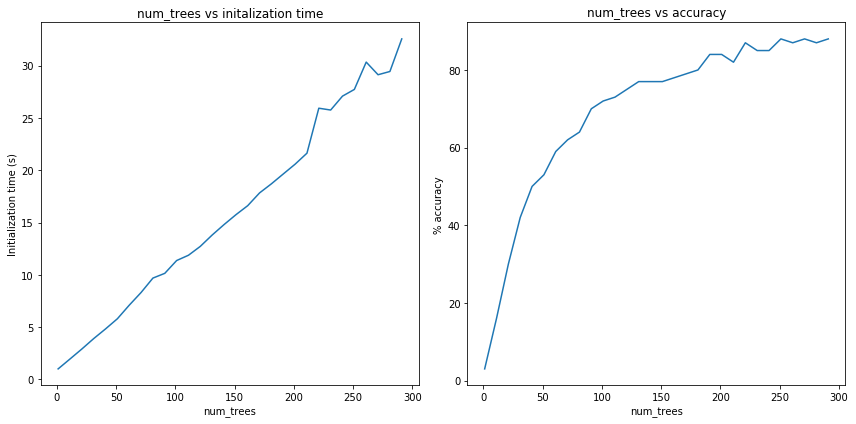

In [19]:
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.plot(x_values, y_values_init)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_trees")
plt.subplot(122)
plt.plot(x_values, y_values_accuracy)
plt.title("num_trees vs accuracy")
plt.ylabel("% accuracy")
plt.xlabel("num_trees")
plt.tight_layout()
plt.show()

##### Initialization:
Initialization time of the annoy indexer increases in a linear fashion with num_trees. Initialization time will vary from corpus to corpus, in the graph above the lee corpus was used

##### Accuracy:
In this dataset, the accuracy seems logarithmically related to the number of trees. We see an improvement in accuracy with more trees, but the relationship is nonlinear. 

### 6. Work with Google word2vec files

Our model can be exported to a word2vec C format. There is a binary and a plain text word2vec format. Both can be read with a variety of other software, or imported back into gensim as a `KeyedVectors` object.

In [20]:
# To export our model as text
model.wv.save_word2vec_format('/tmp/vectors.txt', binary=False)

In [21]:
from smart_open import smart_open
# View the first 3 lines of the exported file

# The first line has the total number of entries and the vector dimension count. 
# The next lines have a key (a string) followed by its vector.
with smart_open('/tmp/vectors.txt') as myfile:
    for i in range(3):
        print(myfile.readline().strip())

b'71290 100'
b'the 0.141686 0.255228 -0.191478 0.232801 0.094346 0.120224 0.075487 0.032936 0.154292 -0.063886 -0.321305 0.128102 0.072219 0.081531 -0.080868 -0.000505 -0.094688 -0.031570 -0.022748 -0.030894 0.118537 -0.091672 0.268565 0.017336 -0.158142 0.028882 -0.354505 -0.248104 0.114017 -0.132821 -0.068284 -0.311653 -0.109148 0.071787 0.391749 0.027252 -0.192908 0.323144 0.100474 -0.049426 -0.157461 -0.289598 0.148029 0.059920 -0.084889 -0.012278 0.041439 0.109375 -0.123536 -0.001224 0.112495 -0.138175 0.114445 -0.208958 0.253858 -0.033594 0.145608 0.295680 -0.008925 0.032524 0.192903 0.035965 0.135603 -0.103187 0.162365 0.031851 0.017547 -0.106019 0.094497 0.071965 0.068053 0.024725 -0.003645 0.001062 0.078102 -0.172048 0.093869 -0.035663 -0.166211 0.176462 0.049964 -0.114905 0.024031 -0.058539 -0.117258 -0.351215 -0.025666 -0.211885 0.036296 -0.326675 -0.182654 -0.019680 -0.189521 -0.206698 -0.100391 0.120583 0.076890 -0.010218 0.084345 -0.277560'
b'of 0.042654 0.329115 -0.06287

In [22]:
# To import a word2vec text model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

In [23]:
# To export our model as binary
model.wv.save_word2vec_format('/tmp/vectors.bin', binary=True)

In [24]:
# To import a word2vec binary model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)

In [25]:
# To create and save Annoy Index from a loaded `KeyedVectors` object (with 100 trees)
annoy_index = AnnoyIndexer(wv, 100)
annoy_index.save('/tmp/mymodel.index')

In [26]:
# Load and test the saved word vectors and saved annoy index
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)
annoy_index = AnnoyIndexer()
annoy_index.load('/tmp/mymodel.index')
annoy_index.model = wv

vector = wv["cat"]
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
print("\nNormal (not Annoy-indexed) Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('cat', 0.9998779296875)
('guppy', 0.5811221897602081)
('prionailurus', 0.5801613330841064)
('leopardus', 0.5798428654670715)
('felis', 0.5769271850585938)
('kitten', 0.5718004107475281)
('asinus', 0.5689475536346436)
('bobcat', 0.567633181810379)
('albino', 0.5676078200340271)
('toed', 0.5668608546257019)
('polydactyl', 0.5667275190353394)

Normal (not Annoy-indexed) Neighbors
('cat', 1.0)
('guppy', 0.6490827798843384)
('prionailurus', 0.6474710702896118)
('leopardus', 0.6469359993934631)
('meow', 0.6448643207550049)
('felis', 0.6420187950134277)
('cats', 0.6419901251792908)
('kitten', 0.63329017162323)
('asinus', 0.6283876299858093)
('nermal', 0.6274536848068237)
('bobcat', 0.6261179447174072)


### Recap
In this notebook we used the Annoy module to build an indexed approximation of our word embeddings. To do so, we did the following steps:
1. Download Text8 Corpus
2. Build Word2Vec Model
3. Construct AnnoyIndex with model & make a similarity query
4. Verify & Evaluate performance
5. Evaluate relationship of `num_trees` to initialization time and accuracy
6. Work with Google's word2vec C formats